In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import corner
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
#
import sys
sys.path.append('../../')
import data.datasets as datasets
import data.data_utils as dutils

Maxes: [6.806522807944578, 4.7266272946623324, 6.99, 5.135572824790997, 4.535379606063847, 4.98457124005185, 6.99, 5.3689269297995965, 3.6370251482181386, 3.5330655070399186, 6.99, 3.621660631153888, 3.6178229631097234, 3.6683209506520233]
Means: [0, 1.0, 0.38231745203150647, 0.5524689394975455, 0.9744951380872597, 0.25565328643413965, 0.44390898141585244, 0.05869842598794717, 0.05197122986802538, 0.8833357664731261, 0.3426064600197094, 0.5642269921964154, 0.6089771393982423, 0.23120448105058056, 0.8877899028867225, 0.6052525996207352] 
Sigmas: [0.15, 0.15, 0.04585936887019356, 0.15106076464816906, 0.3405377149496181, 0.07198951720770981, 0.03489673334399967, 0.0483173988106584, 0.2676733224519612, 0.29318651865316825, 0.022949188156621964, 0.026712391651014827, 0.49451186258972674, 0.03178130828980194, 0.02789074789554624, 0.023142212767425986]
choice [array([1, 3, 2, 0]), array([6, 5, 4, 7]), array([ 8, 11, 10,  9]), array([14, 12, 13, 15])]


/Users/philipharris/miniconda3/lib/python3.10/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


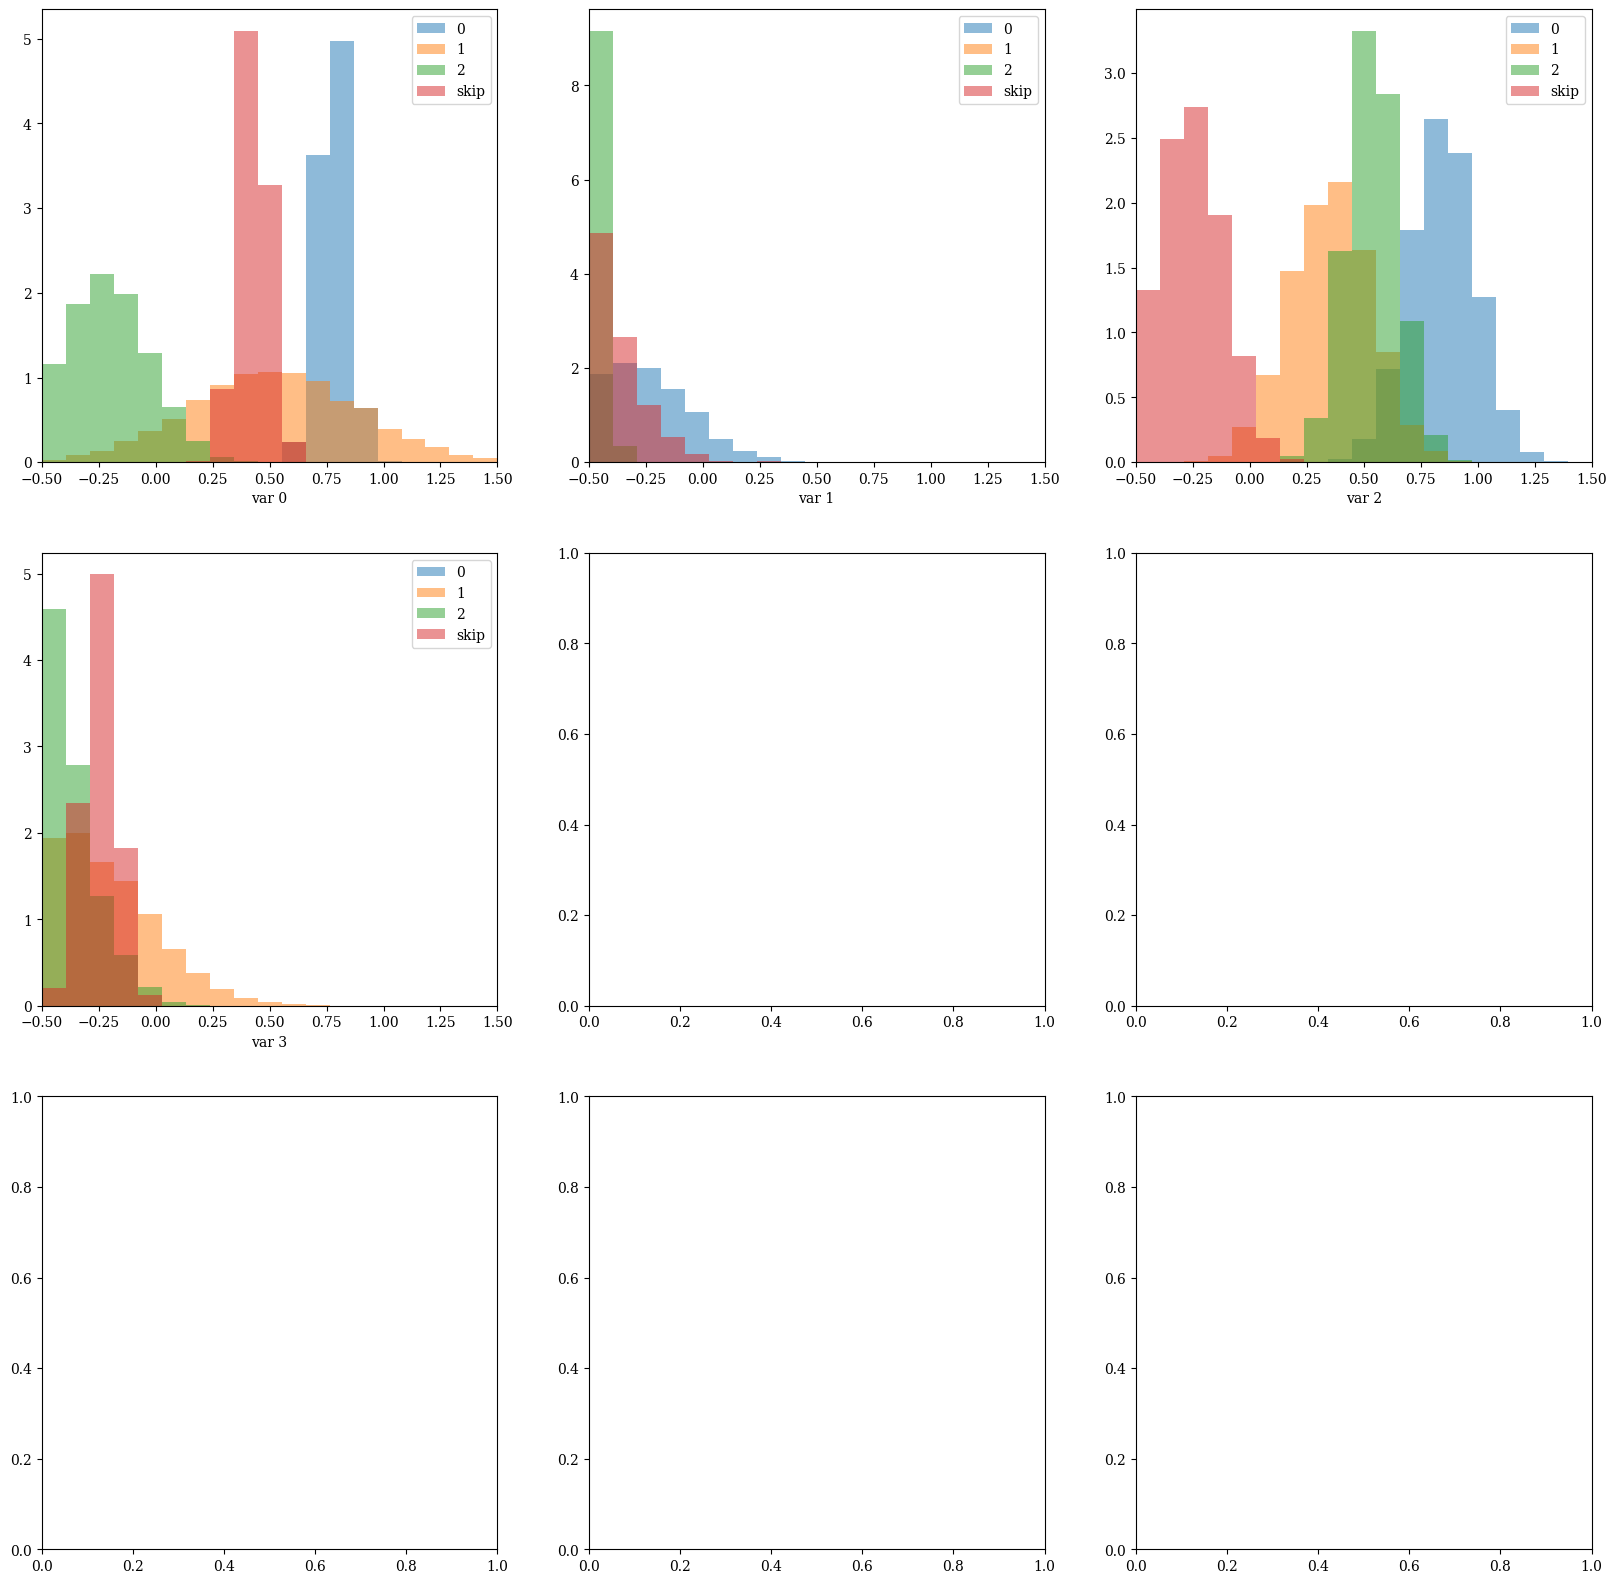

In [5]:
#np.random.seed(1000)
np.random.seed(1234)
embed_dim=4
nsigs=4
ndisc=4
nrand=0
nj_train   = 10000
nj_valid   = 10000
nj_testy   = 10000
tjds       = datasets.FlatDataset(nsigs,ndisc,nj_train,nj_valid,nj_testy,nrand)
tjds.plot()
torch.save(tjds,'flat_data_rand'+str(nrand)+'.pt')

In [ ]:
model_base,output_train,da_out,mc_out,_,_ =tjds.trainQuick(embed_dim=4,num_epochs=5,temp=0.01)
#torch.save(model_base, "model_baseline_"+str(nrand)+".pth")
#model_base = torch.load("model_baseline_"+str(nrand)+".pth")
#model_base,o11,o21,o31,_,_=tjds.trainQuickDataMC(imodel=model_base,embed_dim=embed_dim,num_epochs=5,temp=0.1,iMMD=False)
#model_base,o12,o22,o32,_,_=tjds.trainQuickDataMC(imodel=model_base,embed_dim=embed_dim,num_epochs=5,temp=0.5,iMMD=True)
#

/Users/philipharris/miniconda3/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.
/Users/philipharris/miniconda3/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'projector' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['projector'])`.
/Users/philipharris/miniconda3/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'classifier' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['classifier'])`.
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GP

Sanity Checking: |                                                                                            …

/Users/philipharris/Dropbox/Physics/8S50_2022/test3/phlab-neurips25/experiments/toyjet/../../data/data_utils.py:849: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  i_out=torch.nn.functional.softmax(imodel.classifier(i_out)).numpy()


Epoch [1/5], Loss: 8.1829
Epoch [2/5], Loss: 8.0315
Epoch [3/5], Loss: 8.3018
Epoch [4/5], Loss: 8.1322
Epoch [5/5], Loss: 8.7517


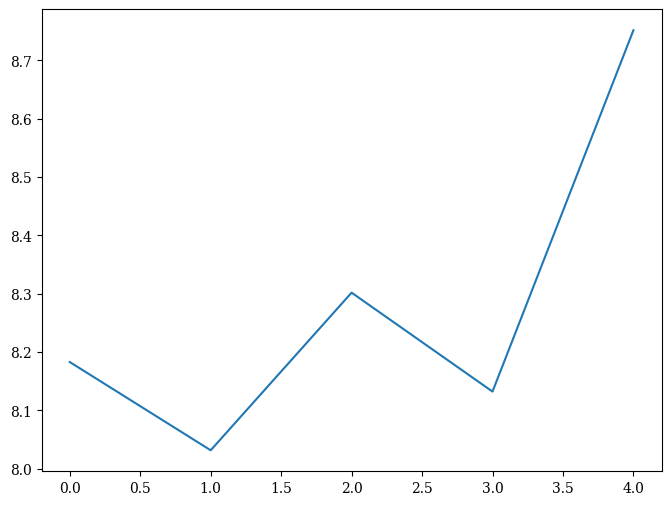

In [8]:
model_base = torch.load("model_baseline_"+str(nrand)+".pth")
train_sfree   = tjds.train_data  [tjds.train_labels != (nsigs-1)]
true_sfree    = tjds.true_data   [tjds.true_labels  != (nsigs-1)]
train_sfrel   = tjds.train_labels[tjds.train_labels != (nsigs-1)]
dutils.train_generic_datamc_prep(5,train_sfree,true_sfree,train_sfrel,model_base,cut_threshold=0.2,temp=0.5)
torch.save(model_base, "model_datamc_"+str(nrand)+".pth")

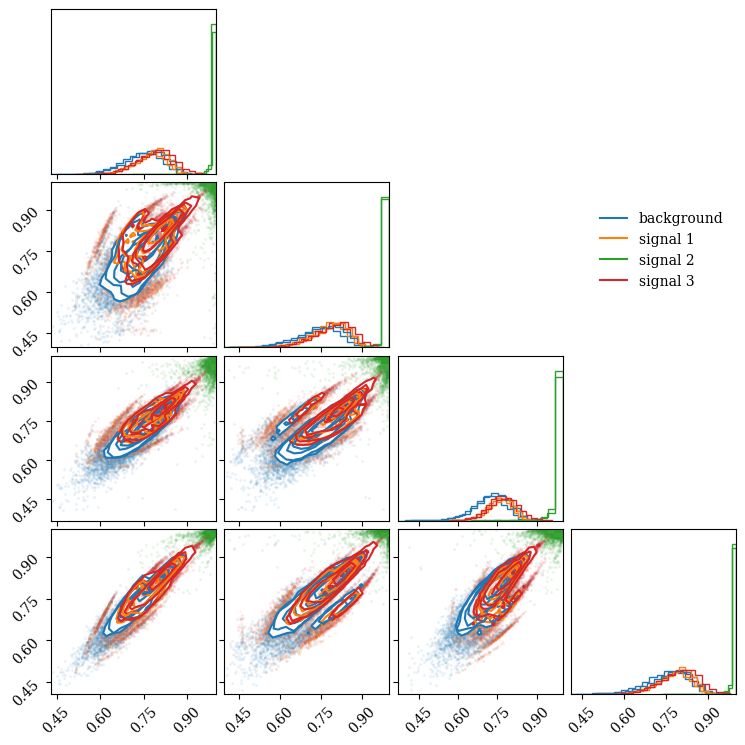

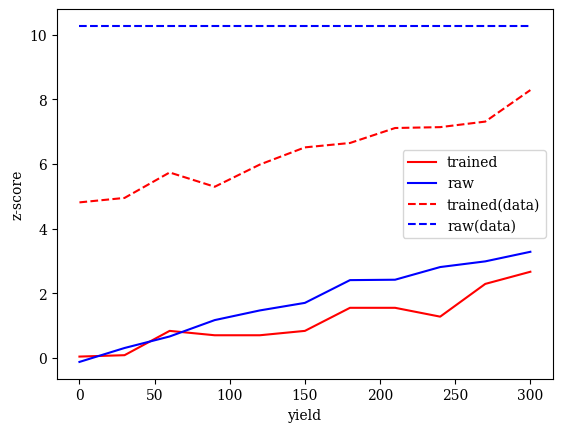

In [9]:
mc_lab=tjds.test_labels.int()
da_lab=tjds.trut_labels.int()
with torch.no_grad():
    mc_out  = (model_base(tjds.test_data.float(),embed=True))
    da_out  = (model_base(tjds.trut_data.float(),embed=True))

tjds.cornerQuick(mc_out,da_out,mc_lab,da_lab)
tjds.zscoreplot(mc_out,da_out,mc_lab,da_lab,tjds.test_data,tjds.trut_data,intoys=50)
